In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg
from flax import nnx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Callable, Optional
from functools import partial
from jaxtyping import PyTree
from tqdm.auto import tqdm

/work/Sebas/miniconda3/envs/BV_Hamiltonian/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def reg_cg(A_func: Callable, b: PyTree, epsilon: float = 1e-4, 
           tol: float = 1e-4, x0: Optional[PyTree] = None, 
           maxiter: int = 10) -> tuple[PyTree, dict]:
    """Regularized CG solver that works with PyTrees."""
    
    def regu_A(x: PyTree) -> PyTree:
        return jax.tree.map(lambda a, b: a + epsilon * b, A_func(x), x)
    
    return cg(regu_A, b, x0=x0, tol=tol, maxiter=maxiter)

In [4]:
# Potential and force field
class DoubleWellPotential:
    @staticmethod
    @jax.jit
    def U(X: jnp.ndarray) -> jnp.ndarray:
        """Potential energy U(x,y) = (x^2-1)^2 + 0.5*y^2"""
        x, y = X[:, 0], X[:, 1]
        return (x**2 - 1)**2 + 0.5 * y**2
    
    @staticmethod
    @jax.jit
    def force(X: jnp.ndarray) -> jnp.ndarray:
        """Force field a(x,y) = -∇U = (-4x(x^2-1), -y)"""
        x, y = X[:, 0], X[:, 1]
        fx = -4 * x * (x**2 - 1)
        fy = -y
        return jnp.stack([fx, fy], axis=1)

In [5]:
# Energy computation (optimized - calls JIT-compiled functions)
def compute_mean_energy(X: jnp.ndarray, Lambda: jnp.ndarray, potential) -> tuple[float, float, float]:
    """
    Compute mean energy per particle.
    
    Note: This function itself is not JIT-compiled, but it calls JIT-compiled 
    potential.U() which provides the performance benefit.
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta/velocities (N, 2)
        potential: potential field with U method
    
    Returns:
        (mean_kinetic, mean_potential, mean_total) energy per particle as floats
    """
    N = X.shape[0]
    ke = 0.5 * jnp.sum(Lambda**2) / N  # Mean kinetic energy per particle
    pe = jnp.sum(potential.U(X)) / N    # Calls JIT-compiled U function
    total = ke + pe
    return float(ke), float(pe), float(total)

In [6]:
class ResNet(nnx.Module):
    def __init__(self, hidden_dim: int, input_dim: int = 2, n_layers: int = 3, 
                 output_dim: int = 2, *, rngs: nnx.Rngs):
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        layers = []
        in_dim = input_dim
        
        # Hidden layers with activations
        for _ in range(n_layers):
            # First layer has bias (for centering), others don't
            
            layers.append(nnx.Linear(in_dim, hidden_dim, use_bias=True,
                                    bias_init=nnx.initializers.zeros,
                                    kernel_init=nnx.initializers.xavier_uniform(), rngs=rngs))

            layers.append(nnx.tanh)
            in_dim = hidden_dim
        
        # Output layer (no bias, no activation)
        layers.append(nnx.Linear(hidden_dim, output_dim, use_bias=False, rngs=rngs))
        
        self.layers = nnx.Sequential(*layers)
    
    def __call__(self, Z: jnp.ndarray) -> jnp.ndarray:
        """Z: (N, input_dim) → (N, output_dim)"""
        return self.layers(Z)

In [7]:
class RandomFeaturesModel(nnx.Module):
    def __init__(self, hidden_dim: int = 15, input_dim: int = 2, n_modes: int = 5, *, rngs: nnx.Rngs):
        self.n_modes = n_modes
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Random Fourier Features (fixed, not learnable)
        # Frequencies: random vectors sampled from N(0, 1)
        self.frequencies = []
        # Phases: random shifts sampled uniformly from [0, 2π]
        self.phases = []
        # Projection layers: project from 2*hidden_dim Fourier features (cos + sin) to output
        self.projection_layers = []

        for _ in range(n_modes):
            # Frequencies initialized from standard normal
            self.frequencies.append(
                jax.random.normal(rngs.params(), (hidden_dim, input_dim))
            )
            # Phases initialized uniformly in [0, 2π]
            self.phases.append(
                jax.random.uniform(rngs.params(), (hidden_dim,), minval=0, maxval=2 * jnp.pi)
            )
            # Projection layer: input is 2*hidden_dim (cos + sin features)
            self.projection_layers.append(
                nnx.Linear(2 * hidden_dim, input_dim, use_bias=False,
                          kernel_init=nnx.initializers.xavier_normal(), rngs=rngs)
            )

    def __call__(self, Z: jnp.ndarray) -> jnp.ndarray:
        """
        Z: (N, input_dim) -> (N, input_dim)
        
        Applies Random Fourier Features: φ(x) = [cos(ω^T x + b), sin(ω^T x + b)]
        """
        out = jnp.zeros_like(Z)

        for i in range(self.n_modes):
            frequencies = self.frequencies[i]  # (hidden_dim, input_dim)
            phases = self.phases[i]            # (hidden_dim,)

            # Project input onto frequency vectors: ω^T x
            # Z: (N, input_dim), frequencies: (hidden_dim, input_dim)
            projection = Z @ frequencies.T     # (N, hidden_dim)

            # Random Fourier Features: concatenate cos and sin
            fourier_features = jnp.concatenate([
                jnp.cos(projection + phases),
                jnp.sin(projection + phases)
            ], axis=-1)                        # (N, 2*hidden_dim)

            # Project to output dimension
            out += self.projection_layers[i](fourier_features)

        return out

In [8]:
class GramMatrixOperator:
    """Matrix-free Gram matrix operator for velocity network"""

    def __init__(self, model: nnx.Module):
        self.model = model
        # Extract graphdef once at initialization to avoid repeated extraction
        self.graphdef, _ = nnx.split(model, nnx.Param)

    def mvp(self, X: jnp.ndarray, eta: PyTree) -> PyTree:
        """
        Compute G @ eta = (J^T J / N) @ eta via JVP then VJP

        Args:
            X: particle positions (N, 2)
            eta: PyTree with same structure as model parameters

        Returns:
            G @ eta as PyTree
        """
        # Get current params from model
        _, params = nnx.split(self.model, nnx.Param)

        def single_sample_contribution(x: jnp.ndarray) -> PyTree:
            def flow_map(p):
                # Use graphdef extracted at init
                model_copy = nnx.merge(self.graphdef, p)
                return model_copy(x[None, :]).flatten()

            # JVP: ∂f/∂θ @ eta
            jvp_result = jax.jvp(flow_map, (params,), (eta,))[1]

            # VJP: (∂f/∂θ)^T @ jvp_result
            _, vjp_fn = jax.vjp(flow_map, params)
            result = vjp_fn(jvp_result)[0]

            return result

        # Vectorize over samples and average
        contributions = jax.vmap(single_sample_contribution)(X)
        return jax.tree.map(lambda x: jnp.mean(x, axis=0), contributions)

    def solve_system(self, X: jnp.ndarray, b: PyTree,
                     epsilon: float = 1e-4, tol: float = 1e-4, maxiter: int = 20) -> tuple:
        """Solve G @ x = b using regularized CG"""
        matvec = lambda eta: self.mvp(X, eta)
        x, info = reg_cg(matvec, b, epsilon=epsilon, tol=tol, maxiter=maxiter)
        return x, info

In [9]:
# Projection operator
def projection_operator(X: jnp.ndarray, Z: jnp.ndarray, model: nnx.Module, 
                       gram_op: GramMatrixOperator,
                       potential: DoubleWellPotential,
                       params: Optional[PyTree] = None,
                       epsilon: float = 1e-4, tol: float = 1e-4) -> tuple:
    """
    Compute DTB projection K_θ[a](X) = J @ (G^{-1} @ (J^T @ a))

    Args:
        X: particle positions (N, 2) - used for force computation
        Z: reference density (M, 2) - used for G matrix and JVP
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        params: optional external parameters (if None, extract from model)
        epsilon: regularization for CG
        tol: tolerance for CG

    Returns:
        p: projected force (N, 2)
        alpha: solution of G @ alpha = J^T @ a (parameter update direction)
        
    """
    N = X.shape[0]

    # Compute force at current particle positions X
    a = potential.force(X)  # (N, 2)

    # Always extract graphdef from model to ensure consistency
    graphdef, model_params = nnx.split(model, nnx.Param)
    
    # Use provided params or extracted model params
    if params is None:
        params = model_params

    # Compute b = J^T @ a / N via VJP (using current X for force)
    def single_sample_vjp(x: jnp.ndarray, a_val: jnp.ndarray) -> PyTree:
        def flow_map(p):
            model_copy = nnx.merge(graphdef, p)
            return model_copy(x[None, :]).flatten()

        _, vjp_fn = jax.vjp(flow_map, params)
        return vjp_fn(a_val)[0]

    contributions = jax.vmap(single_sample_vjp)(X, a)
    b = jax.tree.map(lambda x: jnp.mean(x, axis=0), contributions)

    # Solve G @ alpha = b (G computed using reference density Z)
    alpha, info = gram_op.solve_system(Z, b, epsilon, tol)

    # Compute p = J @ alpha via JVP (using reference density Z)
    def single_sample_jvp(x: jnp.ndarray) -> jnp.ndarray:
        def flow_map(p):
            model_copy = nnx.merge(graphdef, p)
            return model_copy(x[None, :]).flatten()

        return jax.jvp(flow_map, (params,), (alpha,))[1]

    p = jax.vmap(single_sample_jvp)(Z).reshape(N, 2)

    return p, alpha

In [25]:
# DTB Integration steps

def update_model_params(model: nnx.Module, alpha: PyTree, h: float):
    """
    Update model parameters: θ_{k+1} = θ_k + h * α_k
    
    Args:
        model: velocity network (modified in place)
        alpha: parameter update direction (PyTree)
        h: step size
    """
    graphdef, params = nnx.split(model, nnx.Param)
    # Update params: θ + h * α
    new_params = jax.tree.map(lambda p, a: p + h * a, params, alpha)
    # Merge back into model
    updated_model = nnx.merge(graphdef, new_params)
    # Copy updated values back to original model
    _, new_state = nnx.split(updated_model, nnx.Param)
    nnx.update(model, new_state)


def dtb_step(X: jnp.ndarray, Lambda: jnp.ndarray, model: nnx.Module, 
             gram_op: GramMatrixOperator, potential: DoubleWellPotential,
             h: float) -> tuple:
    """
    Single DTB time step using Störmer-Verlet (leapfrog) integrator (fixed parameters)
    
    Störmer-Verlet scheme with projected force:
        1. λ_{n+1/2} = λ_n + (h/2) * p(x_n)
        2. x_{n+1} = x_n + h * λ_{n+1/2}
        3. λ_{n+1} = λ_{n+1/2} + (h/2) * p(x_{n+1})
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        h: time step
        centered: whether to use moving frame
    
    Returns:
        X_new: updated positions (N, 2)
        Lambda_new: updated momenta (N, 2)
        mu: frame center
    """
    # Step 1: Half-step momentum update with projected force at X
    p_n, _ = projection_operator(X, X, model, gram_op, potential)
    Lambda_new = Lambda + (h) * p_n
    
    # Step 2: Full-step position update
    X_new = X + h/2 * (Lambda_new+Lambda)
    
    # Step 3: Half-step momentum update with projected force at X_new
    # p_new, _ = projection_operator(X_new, X_new, model, gram_op, potential)
    # Lambda_new = Lambda_half + (h / 2) * p_new
    
   
    return X_new, Lambda_new


def baseline_dtb_step(X: jnp.ndarray, Lambda: jnp.ndarray, model: nnx.Module, 
                      gram_op: GramMatrixOperator, potential: DoubleWellPotential,
                      h: float) -> tuple:
    """
    Single baseline DTB time step using Störmer-Verlet - updates both particles AND parameters
    
    Störmer-Verlet scheme with projected force + parameter updates:
        1. λ_{n+1/2} = λ_n + (h/2) * p(x_n, θ_n)
        2. θ_{n+1/2} = θ_n + (h/2) * α_n
        3. x_{n+1} = x_n + h * λ_{n+1/2}
        4. λ_{n+1} = λ_{n+1/2} + (h/2) * p(x_{n+1}, θ_{n+1/2})
        5. θ_{n+1} = θ_{n+1/2} + (h/2) * α_{n+1}
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        model: velocity network (modified in place)
        gram_op: Gram matrix operator
        potential: potential field
        h: time step
        centered: whether to use moving frame
    
    Returns:
        X_new: updated positions (N, 2)
        Lambda_new: updated momenta (N, 2)
        mu: frame center
    """
    p,alpha = projection_operator(X,X,model,gram_op,potential)
    Lambda_new = Lambda+h*p
    X_new = X+h/2*(Lambda_new+Lambda)
    update_model_params(model,alpha,h)
    # # Step 1: Half-step momentum update with projected force at X
    # p_n, alpha_n = projection_operator(X, X, model, gram_op, potential)
    # Lambda_half = Lambda + (h / 2) * p_n
    
    # # Step 2: Half-step parameter update
    # update_model_params(model, alpha_n, h / 2)
    
    # # Step 3: Full-step position update
    # X_new = X + h * Lambda_half
    
    # # Step 4: Half-step momentum update with projected force at X_new (with updated θ)
    # p_new, alpha_new = projection_operator(X_new, X_new, model, gram_op, potential)
    # Lambda_new = Lambda_half + (h / 2) * p_new
    
    # # Step 5: Half-step parameter update
    # update_model_params(model, alpha_new, h / 2)

    return X_new, Lambda_new


def two_timescale_dtb_step(X: jnp.ndarray, Lambda: jnp.ndarray,
                           Z_ref: jnp.ndarray,
                        #    theta_fixed: PyTree,      # θ_i - FIXED for computation
                           secondary_theta: PyTree,  # Accumulating θ
                           model: nnx.Module, gram_op: GramMatrixOperator,
                           potential: DoubleWellPotential, h: float) -> tuple:
    """
    Single DTB time step with two-timescale parameter updates.

    Uses Störmer-Verlet scheme where:
    - Particles (X, Lambda) update every step
    - theta_fixed is used for ALL computations (J, G, p) - constant within interval
    - secondary_theta only accumulates alpha updates (not used for computation)
    - G matrix is computed using stored reference density Z_ref and theta_fixed
    - Force is computed using current particle positions X

    Args:
        X: current particle positions (N, 2)
        Lambda: current particle momenta (N, 2)
        Z_ref: stored reference density from last theta update (N, 2)
        theta_fixed: FIXED parameters θ_i for computation (constant within interval)
        secondary_theta: accumulated parameters (only for tracking updates)
        model: velocity network (for graphdef only)
        gram_op: Gram matrix operator
        potential: potential field
        h: time step

    Returns:
        X_new: updated positions (N, 2)
        Lambda_new: updated momenta (N, 2)
        secondary_theta_new: updated accumulated parameters (PyTree)
    """
    _,theta_fixed = nnx.split(model)
    p,alpha = projection_operator(X,Z_ref,model,gram_op,potential,params = theta_fixed)
    Lambda_new = Lambda +h*p
    X_new = X+h/2*(Lambda_new+Lambda)
    secondary_theta_new = jax.tree.map(
        lambda theta_leaf,alpha_leaf: theta_leaf+h*alpha_leaf, secondary_theta,alpha
    )
    # Step 1: Half-step momentum update
    # Use theta_fixed for computation (NOT secondary_theta)
    # Force computed at current X, G matrix and JVP use Z_ref
    # p_n, alpha_n = projection_operator(X, Z_ref, model, gram_op, potential,
    #                                     params=theta_fixed)
    # Lambda_half = Lambda + (h / 2) * p_n

    # # Accumulate into secondary_theta (but don't use it for computation)
    # secondary_theta = jax.tree.map(
    #     lambda theta, alpha: theta + (h / 2) * alpha,
    #     secondary_theta, alpha_n
    # )

    # # Step 2: Full-step position update
    # X_new = X + h * Lambda_half

    # # Step 3: Half-step momentum update
    # # Still use theta_fixed for computation
    # p_new, alpha_new = projection_operator(X_new, Z_ref, model, gram_op, potential,
    #                                         params=theta_fixed)
    # Lambda_new = Lambda_half + (h / 2) * p_new

    # # Accumulate into secondary_theta
    # secondary_theta_new = jax.tree.map(
    #     lambda theta, alpha: theta + (h / 2) * alpha,
    #     secondary_theta, alpha_new
    # )

    return X_new, Lambda_new, secondary_theta_new

In [26]:
# Exact particle dynamics solver (true Hamiltonian dynamics) - JIT optimized

# @jax.jit(static_argnames=)
def exact_dynamics_step_jit(X: jnp.ndarray, Lambda: jnp.ndarray,
                            force_func: Callable, h: float) -> tuple:
    """
    JIT-compiled single step of exact Hamiltonian dynamics using Störmer-Verlet.

    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        force_func: function that computes forces
        h: time step

    Returns:
        X_new, Lambda_new
    """
    # Störmer-Verlet (leapfrog) integrator - second-order symplectic

    # Step 1: Half-step momentum update
    force_n = force_func(X)
    Lambda_half = Lambda + (h / 2) * force_n

    # Step 2: Full-step position update
    X_new = X + h * Lambda_half

    # Step 3: Half-step momentum update with new force
    force_new = force_func(X_new)
    Lambda_new = Lambda_half + (h / 2) * force_new

    return X_new, Lambda_new

def exact_dynamics_step(X: jnp.ndarray, Lambda: jnp.ndarray,
                        potential: DoubleWellPotential, h: float) -> tuple:
    """
    Single step of exact Hamiltonian dynamics using Störmer-Verlet (leapfrog)
    symplectic integrator.

    dx/dt = λ
    dλ/dt = -∇U(x) = force(x)

    Störmer-Verlet scheme:
        1. λ_{n+1/2} = λ_n + (h/2) * F(x_n)
        2. x_{n+1} = x_n + h * λ_{n+1/2}
        3. λ_{n+1} = λ_{n+1/2} + (h/2) * F(x_{n+1})

    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        potential: potential field
        h: time step

    Returns:
        X_new, Lambda_new
    """
    return exact_dynamics_step_jit(X, Lambda, potential.force, h)


def run_exact_dynamics(X0: jnp.ndarray, Lambda0: jnp.ndarray,
                       potential: DoubleWellPotential,
                       M: int, h: float, desc: str = "Exact") -> dict:
    """
    Run exact Hamiltonian particle dynamics.
    
    Args:
        X0: initial positions (N, 2)
        Lambda0: initial momenta (N, 2)
        potential: potential field
        M: number of time steps
        h: time step size
        desc: description for progress bar
    
    Returns:
        metrics: dict with tracked quantities
    """
    metrics = {
        'mu_x': [],
        'mu_y': [],
        'X_history': [],
        'kinetic_energy': [],
        'potential_energy': [],
        'total_energy': [],
    }
    
    X, Lambda = X0, Lambda0
    
    pbar = tqdm(range(M), desc=desc)
    for k in pbar:
        mu = jnp.mean(X, axis=0)
        
        # Track metrics
        metrics['mu_x'].append(float(mu[0]))
        metrics['mu_y'].append(float(mu[1]))
        metrics['X_history'].append(X.copy())
        
        ke, pe, total_e = compute_mean_energy(X, Lambda, potential)
        metrics['kinetic_energy'].append(ke)
        metrics['potential_energy'].append(pe)
        metrics['total_energy'].append(total_e)
        
        pbar.set_postfix({
            'KE': f'{ke:.3f}',
            'PE': f'{pe:.3f}',
            'Total': f'{total_e:.3f}'
        })
        
        # Exact dynamics step (JIT-compiled)
        X, Lambda = exact_dynamics_step(X, Lambda, potential, h)
    
    return metrics


def compare_with_exact(approx_metrics: dict, X0: jnp.ndarray, Lambda0: jnp.ndarray,
                       potential: DoubleWellPotential, h: float,
                       approx_label: str = "Approximate") -> dict:
    """
    Run exact dynamics and compare with approximate solution.
    
    Args:
        approx_metrics: metrics from approximate solver (run_experiment output)
        X0: initial positions
        Lambda0: initial momenta
        potential: potential field
        h: time step (should match the approximate solver)
        approx_label: label for the approximate method
    
    Returns:
        exact_metrics: metrics from exact solver
    """
    M = len(approx_metrics['X_history'])
    
    # Run exact dynamics
    exact_metrics = run_exact_dynamics(X0, Lambda0, potential, M, h, desc="Exact dynamics")
    
    # Plot comparison
    plot_comparison(exact_metrics, approx_metrics, 
                    label1="Exact", label2=approx_label)
    
    # Compute and print error metrics
    print("\n=== Comparison with Exact Dynamics ===")
    
    # Position error over time
    position_errors = []
    for k in range(M):
        X_exact = exact_metrics['X_history'][k]
        X_approx = approx_metrics['X_history'][k]
        # Mean squared error per particle
        mse = float(jnp.mean(jnp.sum((X_exact - X_approx)**2, axis=1)))
        position_errors.append(mse)
    
    print(f"Initial position MSE: {position_errors[0]:.6f}")
    print(f"Final position MSE: {position_errors[-1]:.6f}")
    print(f"Max position MSE: {max(position_errors):.6f}")
    
    # Energy comparison
    exact_final_energy = exact_metrics['total_energy'][-1]
    approx_final_energy = approx_metrics['total_energy'][-1]
    exact_initial_energy = exact_metrics['total_energy'][0]
    
    print(f"\nInitial total energy: {exact_initial_energy:.6f}")
    print(f"Exact final energy: {exact_final_energy:.6f}")
    print(f"Approx final energy: {approx_final_energy:.6f}")
    print(f"Exact energy drift: {abs(exact_final_energy - exact_initial_energy):.6f}")
    print(f"Approx energy drift: {abs(approx_final_energy - exact_initial_energy):.6f}")
    
    # Plot error over time
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(position_errors, 'b-', linewidth=2)
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Position MSE')
    axes[0].set_title('Position Error vs Exact')
    axes[0].grid(True)
    axes[0].set_yscale('log')
    
    # Trajectory comparison (mean position)
    axes[1].plot(exact_metrics['mu_x'], exact_metrics['mu_y'], 
                 'b-', label='Exact', linewidth=2)
    axes[1].plot(approx_metrics['mu_x'], approx_metrics['mu_y'], 
                 'r--', label=approx_label, linewidth=2)
    axes[1].set_xlabel('μ_x')
    axes[1].set_ylabel('μ_y')
    axes[1].set_title('Mean Trajectory Comparison')
    axes[1].legend()
    axes[1].grid(True)
    
    # Energy comparison
    axes[2].plot(exact_metrics['total_energy'], 'b-', label='Exact', linewidth=2)
    axes[2].plot(approx_metrics['total_energy'], 'r--', label=approx_label, linewidth=2)
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Total Energy')
    axes[2].set_title('Energy Comparison')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return exact_metrics

In [27]:
# Experiment runner
def run_experiment(X0: jnp.ndarray, Lambda0: jnp.ndarray, model: nnx.Module,
                   gram_op: GramMatrixOperator, potential: DoubleWellPotential,
                   M: int, h: float, centered: bool = False, 
                   update_params: bool = False,
                   desc: str = "Simulation") -> dict:
    """
    Run DTB simulation and track trajectory and energy.

    Args:
        X0: initial positions (N, 2)
        Lambda0: initial momenta (N, 2)
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        M: number of time steps
        h: time step size
        centered: use moving frame
        update_params: if True, use baseline DTB (update θ); if False, keep θ fixed
        desc: description for progress bar

    Returns:
        metrics: dict with tracked quantities
    """
    metrics = {
        'mu_x': [],
        'mu_y': [],
        'X_history': [],
        'kinetic_energy': [],
        'potential_energy': [],
        'total_energy': [],
    }

    X, Lambda = X0, Lambda0
    
    # Select step function based on whether we update parameters
    step_fn = baseline_dtb_step if update_params else dtb_step

    # Progress bar with energy metrics
    pbar = tqdm(range(M), desc=desc)
    for k in pbar:
        mu = jnp.mean(X, axis=0)

        # Track position metrics
        metrics['mu_x'].append(float(mu[0]))
        metrics['mu_y'].append(float(mu[1]))
        metrics['X_history'].append(X.copy())

        # Track energy metrics
        ke, pe, total_e = compute_mean_energy(X, Lambda, potential)
        metrics['kinetic_energy'].append(ke)
        metrics['potential_energy'].append(pe)
        metrics['total_energy'].append(total_e)

        # Update progress bar with energy info
        pbar.set_postfix({
            'KE': f'{ke:.3f}',
            'PE': f'{pe:.3f}',
            'Total': f'{total_e:.3f}'
        })

        # DTB step (with or without parameter update)
        X, Lambda = step_fn(X, Lambda, model, gram_op, potential, h)

    return metrics

In [28]:
# Two-timescale experiment runner
def run_two_timescale_experiment(X0: jnp.ndarray, Lambda0: jnp.ndarray, 
                                  model: nnx.Module,
                                  gram_op: GramMatrixOperator, 
                                  potential: DoubleWellPotential,
                                  M: int, h: float, 
                                  theta_update_frequency: int = 10,
                                  desc: str = "Two-Timescale") -> dict:
    """
    Run DTB simulation with two-timescale parameter updates.
    
    Parameters (theta) are updated at a slower rate than particles:
    - Particles (X, Lambda) update every step
    - Parameters update every theta_update_frequency steps
    - G matrix uses stored reference density from last parameter update
    - Force uses current particle positions

    Args:
        X0: initial positions (N, 2)
        Lambda0: initial momenta (N, 2)
        model: velocity network (will be modified at theta update boundaries)
        gram_op: Gram matrix operator
        potential: potential field
        M: number of time steps
        h: time step size
        theta_update_frequency: update theta every N steps (default 10)
        desc: description for progress bar

    Returns:
        metrics: dict with tracked quantities including theta_update_steps
    """
    metrics = {
        'mu_x': [],
        'mu_y': [],
        'X_history': [],
        'kinetic_energy': [],
        'potential_energy': [],
        'total_energy': [],
        'theta_update_steps': [],  # Track when theta was updated
    }

    X, Lambda = X0, Lambda0
    
    # Initialize: extract current params as secondary_theta
    graphdef, theta = nnx.split(model, nnx.Param)

    secondary_theta = jax.tree.map(lambda theta_leave: theta_leave, theta)
    
    # Store initial reference density (particles at t_i)
    Z_ref = X0.copy()
    
    # Counter for steps since last theta update
    steps_since_update = 0

    # Progress bar with energy metrics
    pbar = tqdm(range(M), desc=desc)
    for k in pbar:
        # Check if we need to commit theta update (at interval boundary)
        if steps_since_update == theta_update_frequency:
            # Update model params to accumulated secondary_theta
            # updated_model = nnx.merge(graphdef, secondary_theta)
            # _, new_state = nnx.split(updated_model, nnx.Param)
            # nnx.update(model, new_state)
            nnx.update(model,secondary_theta)
            
            # IMPORTANT: Re-extract graphdef and reset secondary_theta from updated model
            # This ensures consistency after the model update
            # graphdef, secondary_theta = nnx.split(model, nnx.Param)
            
            # Store new reference density
            Z_ref = X.copy()
            
            # Reset counter
            steps_since_update = 0
            
            # Track when theta was updated
            metrics['theta_update_steps'].append(k)

        # Track position metrics
        mu = jnp.mean(X, axis=0)
        metrics['mu_x'].append(float(mu[0]))
        metrics['mu_y'].append(float(mu[1]))
        metrics['X_history'].append(X.copy())

        # Track energy metrics
        ke, pe, total_e = compute_mean_energy(X, Lambda, potential)
        metrics['kinetic_energy'].append(ke)
        metrics['potential_energy'].append(pe)
        metrics['total_energy'].append(total_e)

        # Update progress bar with energy info
        pbar.set_postfix({
            'KE': f'{ke:.3f}',
            'PE': f'{pe:.3f}',
            'Total': f'{total_e:.3f}',
            'θ_step': steps_since_update
        })

        # Two-timescale DTB step
        X, Lambda, secondary_theta = two_timescale_dtb_step(
            X, Lambda, Z_ref, secondary_theta,
            model, gram_op, potential, h
        )
        
        steps_since_update += 1

    return metrics

In [29]:
# Visualization
def plot_comparison(metrics1: dict, metrics2: dict, time_indices: list = None,
                    label1: str = "Method 1", label2: str = "Method 2"):
    """Plot comparison of two experiments at multiple time steps"""
    
    M = len(metrics1['X_history'])
    if time_indices is None:
        # Default: show initial, 1/3, 2/3, and final times
        time_indices = [0, M//3, 2*M//3, M-1]
    
    n_times = len(time_indices)
    fig, axes = plt.subplots(4, n_times, figsize=(4*n_times, 16))
    
    # Row 0: Method 1 particles at different times
    for i, t_idx in enumerate(time_indices):
        X = metrics1['X_history'][t_idx]
        axes[0, i].scatter(X[:, 0], X[:, 1], alpha=0.3, s=5)
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('y')
        axes[0, i].set_title(f'{label1} (t={t_idx})')
        axes[0, i].set_xlim(-3, 3)
        axes[0, i].set_ylim(-2, 2)
        axes[0, i].grid(True)
    
    # Row 1: Method 2 particles at different times
    for i, t_idx in enumerate(time_indices):
        X = metrics2['X_history'][t_idx]
        axes[1, i].scatter(X[:, 0], X[:, 1], alpha=0.3, s=5, color='orange')
        axes[1, i].set_xlabel('x')
        axes[1, i].set_ylabel('y')
        axes[1, i].set_title(f'{label2} (t={t_idx})')
        axes[1, i].set_xlim(-3, 3)
        axes[1, i].set_ylim(-2, 2)
        axes[1, i].grid(True)
    
    # Row 2: Trajectories and position metrics
    axes[2, 0].plot(metrics1['mu_x'], metrics1['mu_y'],
                    'o-', label=label1, linewidth=2, markersize=4)
    axes[2, 0].plot(metrics2['mu_x'], metrics2['mu_y'],
                    's-', label=label2, linewidth=2, markersize=4, color='orange')
    axes[2, 0].set_xlabel('μ_x')
    axes[2, 0].set_ylabel('μ_y')
    axes[2, 0].set_title('Mean Trajectory')
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    
    axes[2, 1].plot(metrics1['mu_x'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[2, 1].plot(metrics2['mu_x'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[2, 1].set_xlabel('Time Step')
    axes[2, 1].set_ylabel('μ_x')
    axes[2, 1].set_title('Mean x-position over time')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    if n_times >= 3:
        axes[2, 2].plot(metrics1['mu_y'], 'o-', label=label1, linewidth=2, markersize=3)
        axes[2, 2].plot(metrics2['mu_y'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
        axes[2, 2].set_xlabel('Time Step')
        axes[2, 2].set_ylabel('μ_y')
        axes[2, 2].set_title('Mean y-position over time')
        axes[2, 2].legend()
        axes[2, 2].grid(True)
    
    for i in range(3, n_times):
        axes[2, i].axis('off')
    
    # Row 3: Energy plots
    axes[3, 0].plot(metrics1['total_energy'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[3, 0].plot(metrics2['total_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[3, 0].set_xlabel('Time Step')
    axes[3, 0].set_ylabel('Energy')
    axes[3, 0].set_title('Total Energy (per particle)')
    axes[3, 0].legend()
    axes[3, 0].grid(True)
    
    axes[3, 1].plot(metrics1['kinetic_energy'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[3, 1].plot(metrics2['kinetic_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[3, 1].set_xlabel('Time Step')
    axes[3, 1].set_ylabel('Energy')
    axes[3, 1].set_title('Kinetic Energy (per particle)')
    axes[3, 1].legend()
    axes[3, 1].grid(True)
    
    if n_times >= 3:
        axes[3, 2].plot(metrics1['potential_energy'], 'o-', label=label1, linewidth=2, markersize=3)
        axes[3, 2].plot(metrics2['potential_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
        axes[3, 2].set_xlabel('Time Step')
        axes[3, 2].set_ylabel('Energy')
        axes[3, 2].set_title('Potential Energy (per particle)')
        axes[3, 2].legend()
        axes[3, 2].grid(True)
    
    for i in range(3, n_times):
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [30]:
# Animation - Side-by-side comparison GIF
def create_comparison_animation(metrics1: dict, metrics2: dict,
                                potential, filename: str = 'comparison.gif',
                                fps: int = 10, xlim=(-3, 3), ylim=(-2, 2),
                                label1: str = "Method 1", label2: str = "Method 2"):
    """
    Create side-by-side GIF animation comparing two experiments.
    
    Args:
        metrics1: metrics from first experiment
        metrics2: metrics from second experiment
        potential: potential field for contour background
        filename: output GIF filename
        fps: frames per second
        xlim, ylim: axis limits
        label1, label2: labels for the two methods
    
    Returns:
        animation object
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Draw potential contours as background on both axes
    xx, yy = jnp.meshgrid(jnp.linspace(xlim[0], xlim[1], 500),
                          jnp.linspace(ylim[0], ylim[1], 500))
    ZZ = potential.U(jnp.stack([xx.ravel(), yy.ravel()], axis=1)).reshape(xx.shape)
    
    for ax in axes:
        ax.contourf(xx, yy, ZZ, levels=100, alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
    
    axes[0].set_title(label1)
    axes[1].set_title(label2)
    
    # Initialize scatter plots
    scatter1 = axes[0].scatter([], [], alpha=0.3, s=5, c='blue')
    scatter2 = axes[1].scatter([], [], alpha=0.3, s=5, c='orange')
    title = fig.suptitle('', fontsize=12)
    
    def init():
        scatter1.set_offsets(jnp.empty((0, 2)))
        scatter2.set_offsets(jnp.empty((0, 2)))
        return scatter1, scatter2, title
    
    def update(frame):
        scatter1.set_offsets(metrics1['X_history'][frame])
        scatter2.set_offsets(metrics2['X_history'][frame])
        title.set_text(f'Time step: {frame}')
        return scatter1, scatter2, title
    
    anim = FuncAnimation(fig, update, init_func=init,
                         frames=len(metrics1['X_history']),
                         interval=1000//fps, blit=True)
    
    anim.save(filename, writer='pillow', fps=fps)
    plt.close()
    print(f"Animation saved to {filename}")
    return anim

In [31]:
# =============================================================================
# Compare Baseline (every-step update) vs Two-Timescale approach
# =============================================================================

def compare_update_schemes(N: int = 500, M: int = 100, h: float = 0.1,
                           theta_update_frequency: int = 10,
                           hidden_dim: int = 64, n_layers: int = 3,
                           seed: int = 42):
    """
    Compare baseline DTB (theta updates every step) with two-timescale DTB.
    
    Args:
        N: number of particles
        M: number of time steps
        h: time step size
        theta_update_frequency: for two-timescale, update theta every N steps
        hidden_dim: hidden dimension for ResNet
        n_layers: number of layers in ResNet
        seed: random seed for reproducibility
    
    Returns:
        baseline_metrics, two_timescale_metrics
    """
    # Set random seed
    key = jax.random.PRNGKey(seed)
    key, key_init, key_model1, key_model2 = jax.random.split(key, 4)
    
    # Initialize potential
    potential = DoubleWellPotential()
    
    # Initialize particles: start in left well with small random velocities
    X0 = jax.random.normal(key_init, (N, 2)) * 0.3 + jnp.array([-1.0, 0.0])
    Lambda0 = jnp.tile(jnp.array([2.0, 0.0]), (N, 1))
    
    print(f"=== Comparison: Baseline vs Two-Timescale ===")
    print(f"Particles: {N}, Steps: {M}, dt: {h}")
    print(f"Two-timescale theta update frequency: every {theta_update_frequency} steps")
    print(f"Model: ResNet with hidden_dim={hidden_dim}, n_layers={n_layers}")
    print()
    
    # Create two separate models with same initialization for fair comparison
    model_baseline = ResNet(hidden_dim=hidden_dim, n_layers=n_layers, 
                            rngs=nnx.Rngs(key_model1))
    model_two_ts = ResNet(hidden_dim=hidden_dim, n_layers=n_layers, 
                          rngs=nnx.Rngs(key_model1))  # Same key for same init
    
    # Copy initial params to ensure both start identically
    graphdef, init_params = nnx.split(model_baseline, nnx.Param)
    model_two_ts = nnx.merge(graphdef, init_params)
    
    # Create Gram operators
    gram_op_baseline = GramMatrixOperator(model_baseline)
    gram_op_two_ts = GramMatrixOperator(model_two_ts)

    # Reset model for two-timescale (use fresh copy)
    model_two_ts = nnx.merge(graphdef, init_params)
    gram_op_two_ts = GramMatrixOperator(model_two_ts)
    
    # Run two-timescale experiment
    print(f"\nRunning Two-Timescale DTB (theta updates every {theta_update_frequency} steps)...")
    two_ts_metrics = run_two_timescale_experiment(
        X0.copy(), Lambda0.copy(), model_two_ts, gram_op_two_ts, potential,
        M=M, h=h, theta_update_frequency=theta_update_frequency,
        desc=f"Two-Timescale (freq={theta_update_frequency})"
    )
    
    
    # Run baseline experiment (theta updates every step)
    print("Running Baseline DTB (theta updates every step)...")
    baseline_metrics = run_experiment(
        X0.copy(), Lambda0.copy(), model_baseline, gram_op_baseline, potential,
        M=M, h=h, update_params=True, desc="Baseline DTB"
    )
    
    
    # Plot comparison
    print("\n=== Results ===")
    plot_comparison(baseline_metrics, two_ts_metrics,
                    label1="Baseline (every step)", 
                    label2=f"Two-Timescale (every {theta_update_frequency})")
    
    # Print summary statistics
    print("\n=== Energy Summary ===")
    print(f"{'Method':<30} {'Initial E':>12} {'Final E':>12} {'Drift':>12}")
    print("-" * 70)
    
    baseline_init_e = baseline_metrics['total_energy'][0]
    baseline_final_e = baseline_metrics['total_energy'][-1]
    baseline_drift = abs(baseline_final_e - baseline_init_e)
    print(f"{'Baseline (every step)':<30} {baseline_init_e:>12.4f} {baseline_final_e:>12.4f} {baseline_drift:>12.4f}")
    
    two_ts_init_e = two_ts_metrics['total_energy'][0]
    two_ts_final_e = two_ts_metrics['total_energy'][-1]
    two_ts_drift = abs(two_ts_final_e - two_ts_init_e)
    print(f"{f'Two-Timescale (every {theta_update_frequency})':<30} {two_ts_init_e:>12.4f} {two_ts_final_e:>12.4f} {two_ts_drift:>12.4f}")
    
    # Print theta update info
    if 'theta_update_steps' in two_ts_metrics:
        n_updates = len(two_ts_metrics['theta_update_steps'])
        print(f"\nTwo-timescale theta updates: {n_updates} times at steps {two_ts_metrics['theta_update_steps']}")
    
    return baseline_metrics, two_ts_metrics

In [45]:
N = 2500
M = 50
h =0.01
hidden_dim = 80
n_layers = 2

=== Comparison: Baseline vs Two-Timescale ===
Particles: 2500, Steps: 50, dt: 0.01
Two-timescale theta update frequency: every 10 steps
Model: ResNet with hidden_dim=80, n_layers=2


Running Two-Timescale DTB (theta updates every 10 steps)...


Two-Timescale (freq=10):   0%|          | 0/50 [00:00<?, ?it/s, KE=2.000, PE=0.454, Total=2.454, θ_step=0]2026-01-29 12:12:52.242230: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2026-01-29 12:12:53.494747: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2026-01-29 12:12:56.262835: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working arou

Running Baseline DTB (theta updates every step)...


Baseline DTB: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s, KE=1.538, PE=0.934, Total=2.473]



=== Results ===


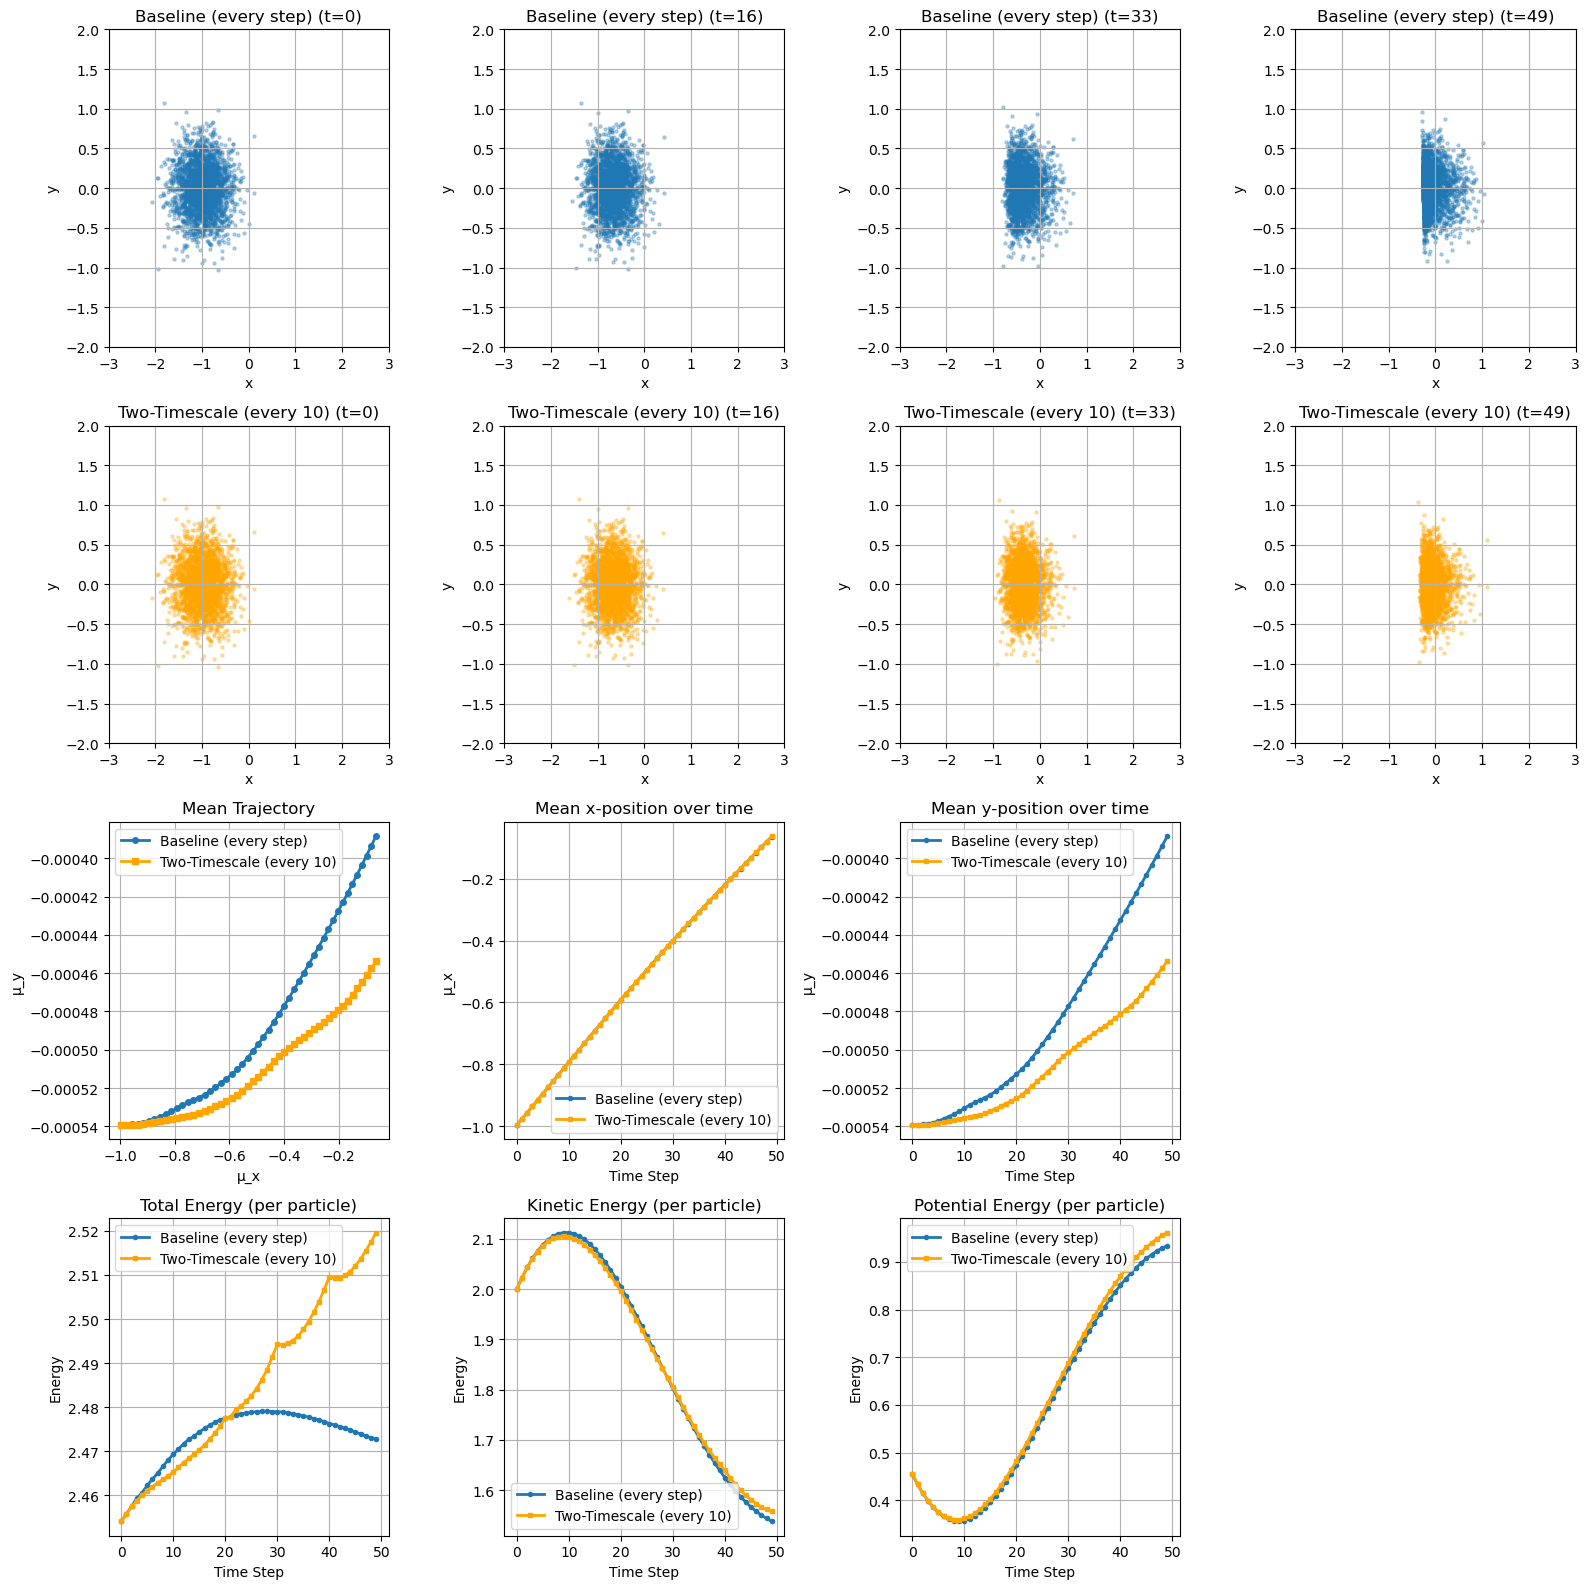


=== Energy Summary ===
Method                            Initial E      Final E        Drift
----------------------------------------------------------------------
Baseline (every step)                2.4541       2.4727       0.0186
Two-Timescale (every 10)             2.4541       2.5196       0.0655

Two-timescale theta updates: 4 times at steps [10, 20, 30, 40]


In [46]:
# Run the comparison
baseline_metrics, two_ts_metrics = compare_update_schemes(
    N=N,                      # Number of particles
    M=M,                      # Number of time steps
    h=h,                      # Time step
    theta_update_frequency=10,  # Two-timescale: update theta every 10 steps
    hidden_dim=hidden_dim,              # ResNet hidden dimension
    n_layers=n_layers,                 # ResNet layers
    seed=0                     # Random seed for reproducibility
)


Comparing fixed θ with Exact Dynamics


Exact dynamics:   0%|          | 0/50 [00:00<?, ?it/s, KE=2.056, PE=0.398, Total=2.454]

Exact dynamics: 100%|██████████| 50/50 [00:00<00:00, 173.63it/s, KE=1.525, PE=0.930, Total=2.454]


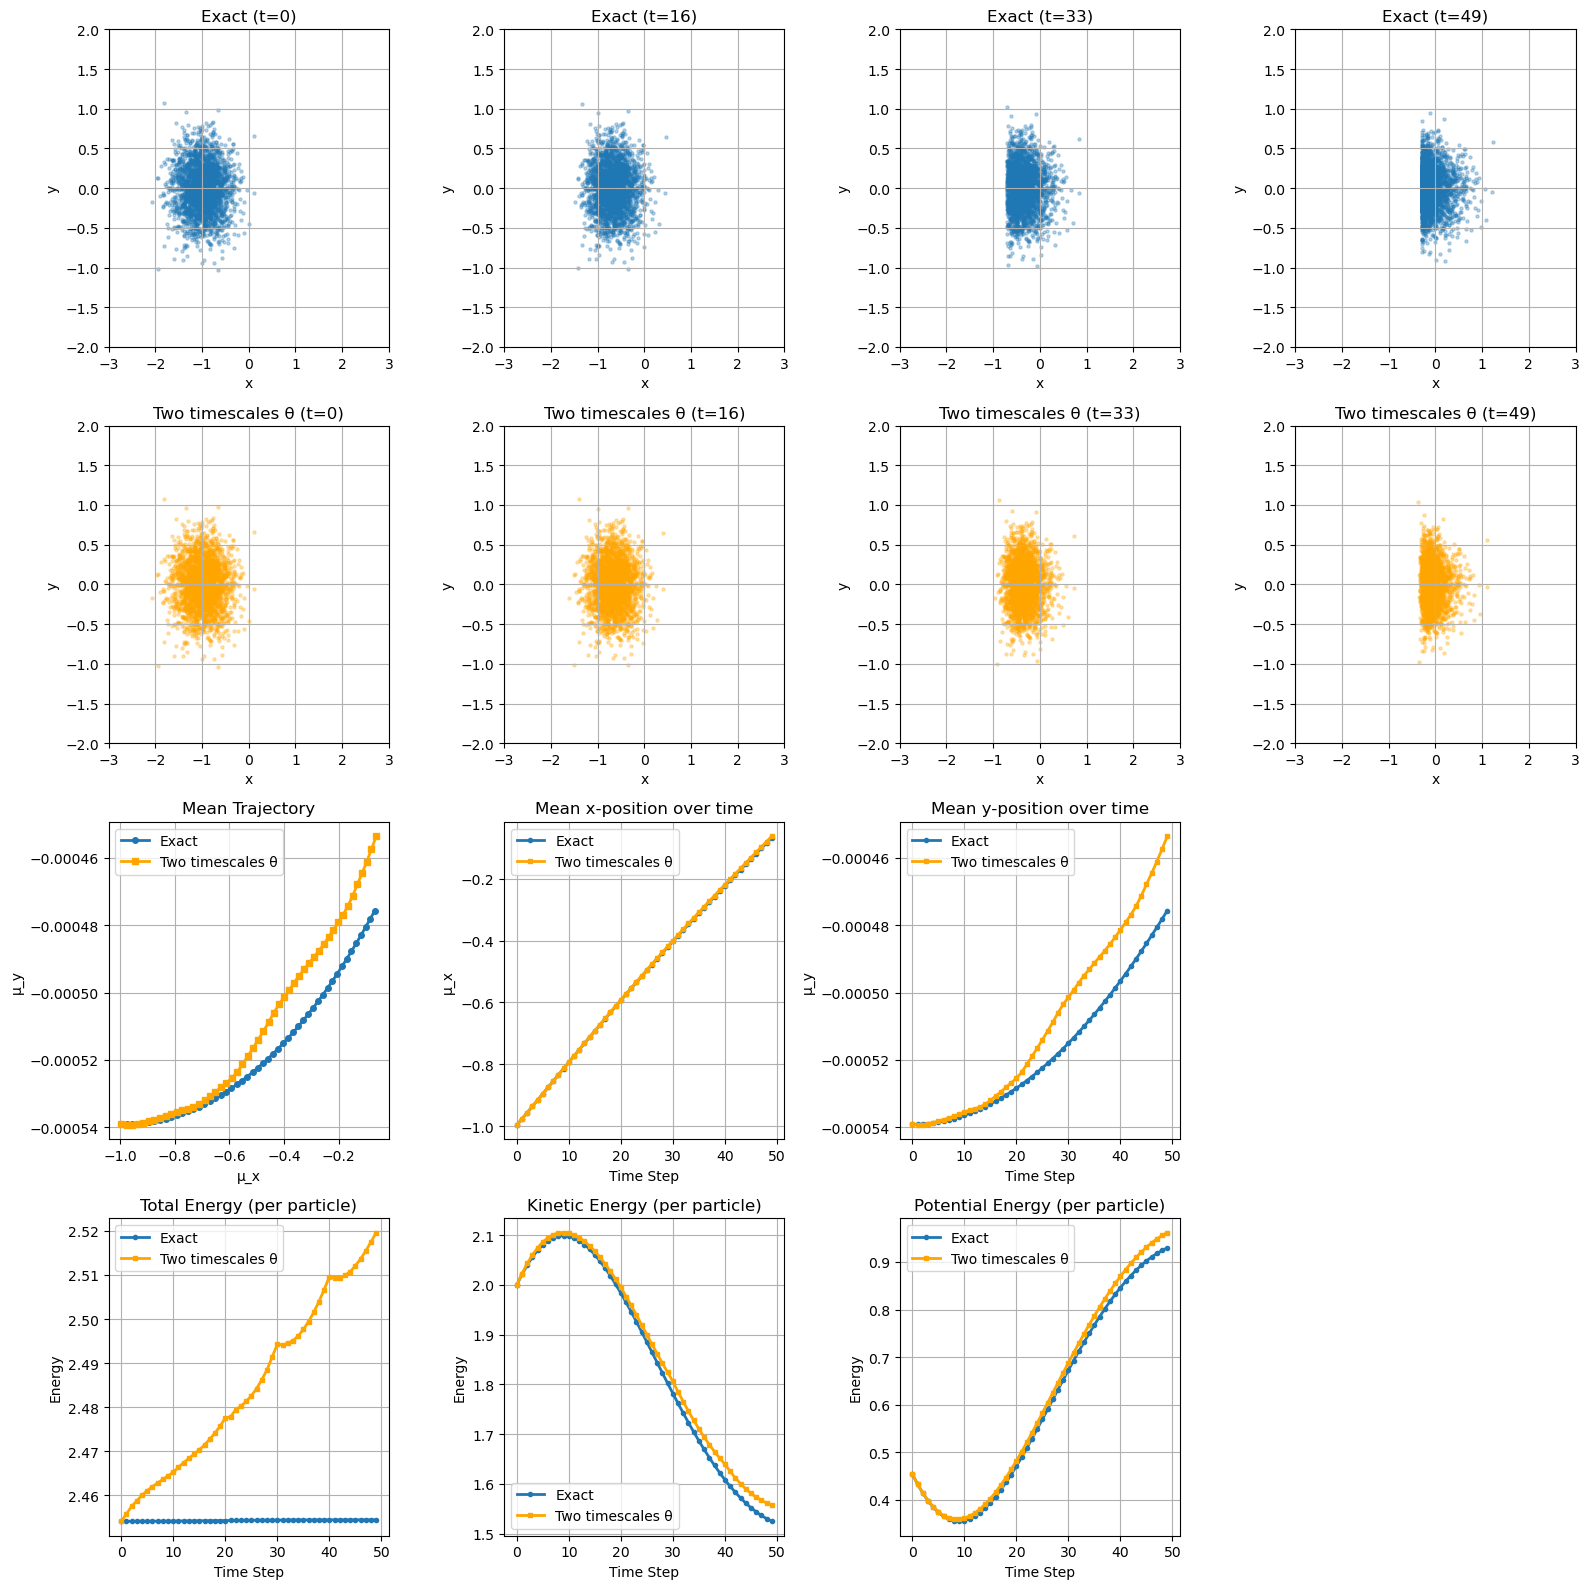


=== Comparison with Exact Dynamics ===
Initial position MSE: 0.000000
Final position MSE: 0.003763
Max position MSE: 0.003763

Initial total energy: 2.454112
Exact final energy: 2.454444
Approx final energy: 2.519621
Exact energy drift: 0.000332
Approx energy drift: 0.065510


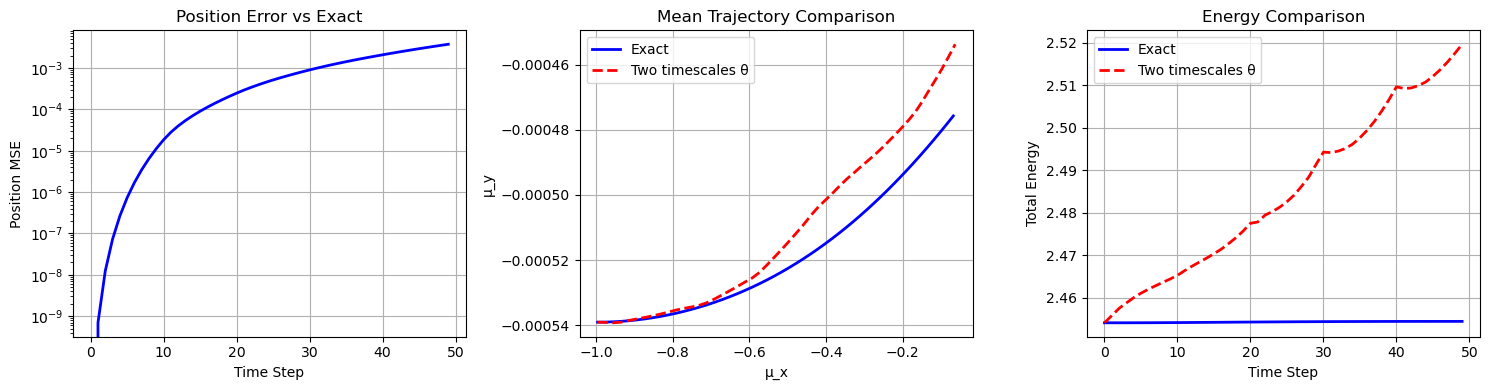


Comparing Baseline DTB with Exact Dynamics


Exact dynamics: 100%|██████████| 50/50 [00:00<00:00, 274.91it/s, KE=1.525, PE=0.930, Total=2.454]


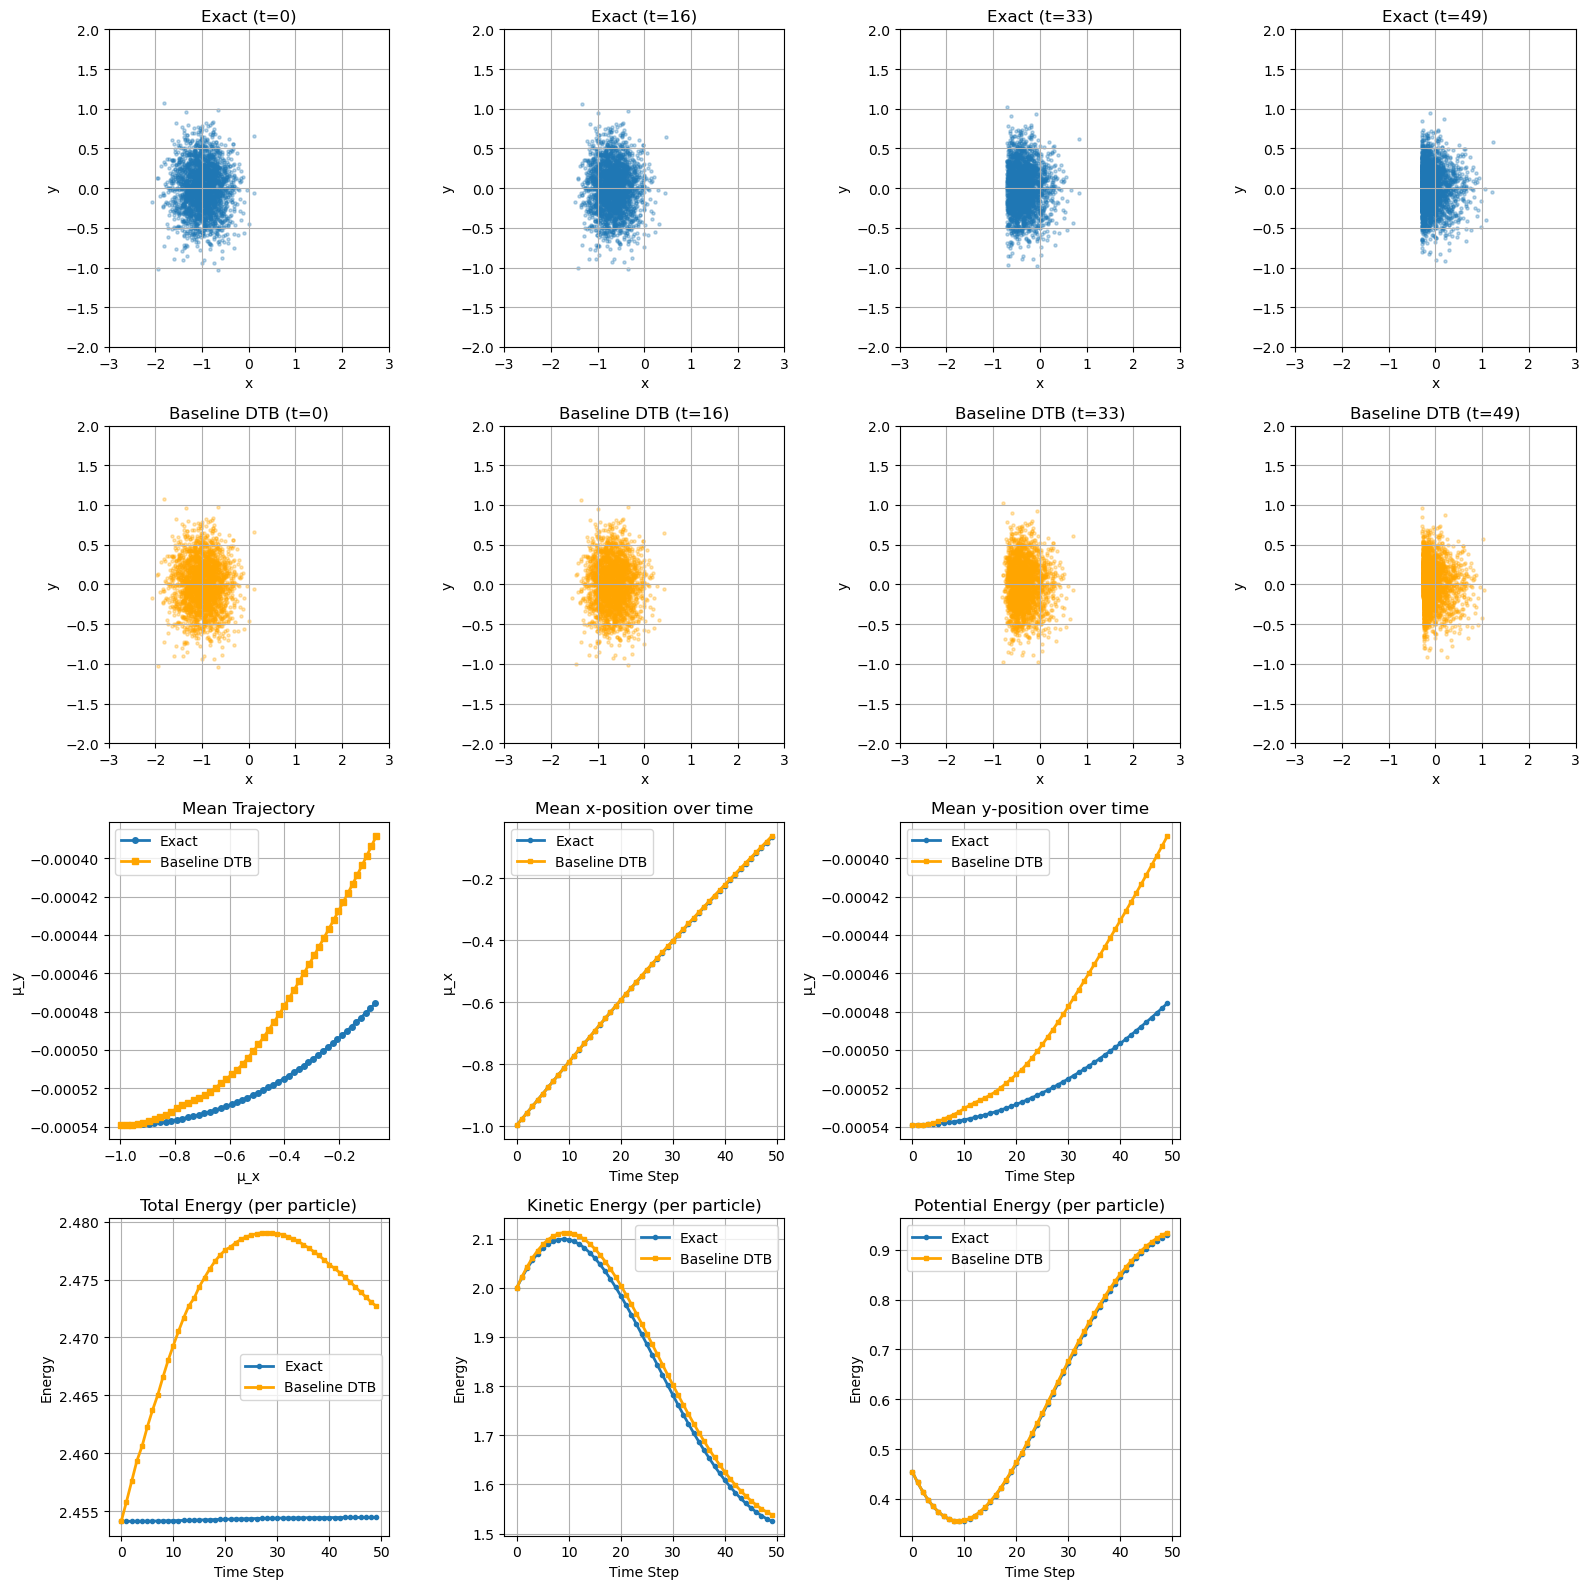


=== Comparison with Exact Dynamics ===
Initial position MSE: 0.000000
Final position MSE: 0.000460
Max position MSE: 0.000460

Initial total energy: 2.454112
Exact final energy: 2.454444
Approx final energy: 2.472706
Exact energy drift: 0.000332
Approx energy drift: 0.018594


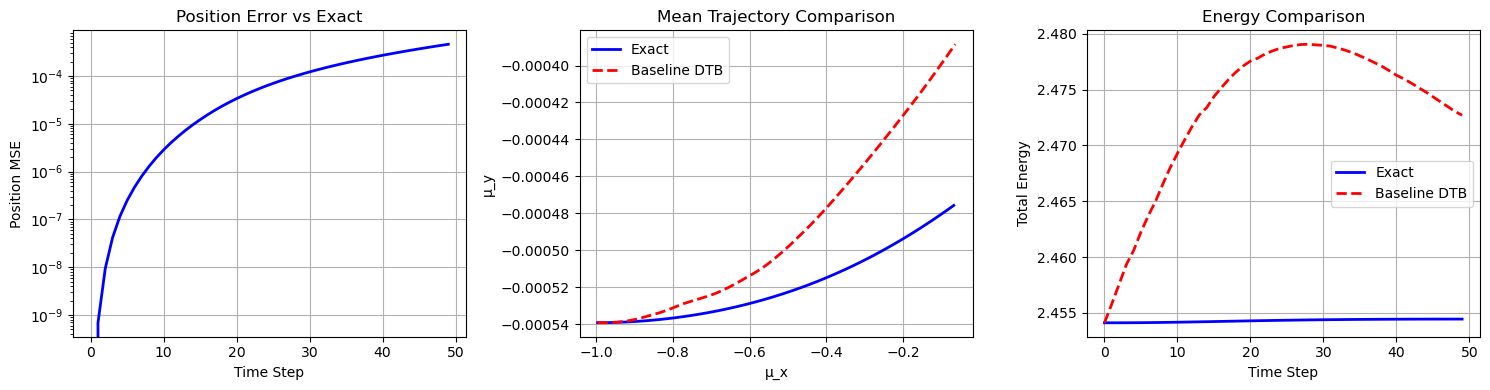

In [47]:
#baseline_metrics, two_ts_metrics 
X0 = baseline_metrics['X_history'][0]
Lambda0 = jnp.tile(jnp.array([2.0, 0.0]), (len(X0), 1))

# Compare approximate solutions with exact dynamics
print("\n" + "="*60)
print("Comparing fixed θ with Exact Dynamics")
print("="*60)
exact_metrics = compare_with_exact(two_ts_metrics, X0, Lambda0, DoubleWellPotential, h, 
                                    approx_label="Two timescales θ")

print("\n" + "="*60)
print("Comparing Baseline DTB with Exact Dynamics")  
print("="*60)
_ = compare_with_exact(baseline_metrics, X0, Lambda0, DoubleWellPotential, h,
                       approx_label="Baseline DTB")

In [44]:
# =============================================================================
# Study effect of different theta update frequencies
# =============================================================================

def study_update_frequencies(frequencies: list = [1, 5, 10, 20],
                              N: int = 2500, M: int = 150, h: float = 0.005,
                              hidden_dim: int = 128, n_layers: int = 2,
                              seed: int = 0):
    """
    Compare two-timescale DTB with different theta update frequencies.
    
    Args:
        frequencies: list of update frequencies to test
        N, M, h: simulation parameters
        hidden_dim, n_layers: model parameters
        seed: random seed
    
    Returns:
        dict mapping frequency -> metrics
    """
    key = jax.random.PRNGKey(seed)
    key, key_init, key_model = jax.random.split(key, 3)
    
    potential = DoubleWellPotential()
    X0 = jax.random.normal(key_init, (N, 2)) * 0.3 + jnp.array([-1.0, 0.0])
    Lambda0 = jnp.tile(jnp.array([2.,0.]),(N,1))
    
    # Create reference model for initial params
    ref_model = ResNet(hidden_dim=hidden_dim, n_layers=n_layers, rngs=nnx.Rngs(key_model))
    graphdef, init_params = nnx.split(ref_model, nnx.Param)
    
    all_metrics = {}
    
    print(f"=== Studying Different Update Frequencies ===")
    print(f"Frequencies to test: {frequencies}")
    print()
    
    for freq in frequencies:
        print(f"--- Running with theta_update_frequency = {freq} ---")
        
        # Create fresh model with same initial params
        model = nnx.merge(graphdef, init_params)
        gram_op = GramMatrixOperator(model)
        
        if freq == 1:
            # frequency=1 means update every step, use baseline
            metrics = run_experiment(
                X0.copy(), Lambda0.copy(), model, gram_op, potential,
                M=M, h=h, update_params=True, desc=f"freq={freq}"
            )
        else:
            metrics = run_two_timescale_experiment(
                X0.copy(), Lambda0.copy(), model, gram_op, potential,
                M=M, h=h, theta_update_frequency=freq, desc=f"freq={freq}"
            )
        
        all_metrics[freq] = metrics
        print()
    
    # Plot comparison of all frequencies
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = plt.cm.viridis(jnp.linspace(0, 1, len(frequencies)))
    
    # Total energy over time
    for i, freq in enumerate(frequencies):
        axes[0, 0].plot(all_metrics[freq]['total_energy'], 
                        label=f'freq={freq}', color=colors[i], linewidth=2)
    axes[0, 0].set_xlabel('Time Step')
    axes[0, 0].set_ylabel('Total Energy')
    axes[0, 0].set_title('Total Energy vs Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Mean x position over time
    for i, freq in enumerate(frequencies):
        axes[0, 1].plot(all_metrics[freq]['mu_x'], 
                        label=f'freq={freq}', color=colors[i], linewidth=2)
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('μ_x')
    axes[0, 1].set_title('Mean x-Position vs Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Mean trajectory in phase space
    for i, freq in enumerate(frequencies):
        axes[1, 0].plot(all_metrics[freq]['mu_x'], all_metrics[freq]['mu_y'],
                        label=f'freq={freq}', color=colors[i], linewidth=2)
    axes[1, 0].set_xlabel('μ_x')
    axes[1, 0].set_ylabel('μ_y')
    axes[1, 0].set_title('Mean Trajectory')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Energy drift summary
    drifts = []
    for freq in frequencies:
        init_e = all_metrics[freq]['total_energy'][0]
        final_e = all_metrics[freq]['total_energy'][-1]
        drifts.append(abs(final_e - init_e))
    
    axes[1, 1].bar(range(len(frequencies)), drifts, color=colors, tick_label=[str(f) for f in frequencies])
    axes[1, 1].set_xlabel('Update Frequency')
    axes[1, 1].set_ylabel('Energy Drift |E_final - E_initial|')
    axes[1, 1].set_title('Energy Drift by Update Frequency')
    axes[1, 1].grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n=== Summary Table ===")
    print(f"{'Frequency':<12} {'Initial E':>12} {'Final E':>12} {'Drift':>12} {'Max E':>12} {'Min E':>12}")
    print("-" * 76)
    for freq in frequencies:
        init_e = all_metrics[freq]['total_energy'][0]
        final_e = all_metrics[freq]['total_energy'][-1]
        max_e = max(all_metrics[freq]['total_energy'])
        min_e = min(all_metrics[freq]['total_energy'])
        drift = abs(final_e - init_e)
        print(f"{freq:<12} {init_e:>12.4f} {final_e:>12.4f} {drift:>12.4f} {max_e:>12.4f} {min_e:>12.4f}")
    
    return all_metrics

In [ ]:

freq_metrics = study_update_frequencies(
    frequencies=[1, 5, 10, 25, 50, 75, 100],  # 1 = every step (baseline)
    N=2500, M=250, h=0.005,
    seed=42
)

=== Studying Different Update Frequencies ===
Frequencies to test: [1, 5, 10, 25, 50, 75, 100]

--- Running with theta_update_frequency = 1 ---


freq=1:  45%|████▍     | 112/250 [01:52<02:13,  1.04it/s, KE=1.507, PE=0.942, Total=2.449]